# Accessing Data in Cloud-Optimized GeoTIFFs (COGs) with Python

Cloud-Optimized GeoTIFFs (COGs) are a sub-specification of GeoTIFF, which itself extends the TIFF format. COGs are designed to store raster data in a manner optimized for cloud environments. These files enable efficient, scalable workflows for geospatial analysis and are widely used in remote sensing and GIS. In this notebook, we're going to align our reads according to the internal tile structure to illustrate how partial reads work to minimize the data that needs to be downloaded. Please keep in mind that in practice, the internal tile structure is *not* something you'll need to think about explicitly.

The benefits to using the COG format, as we'll see, are significant. At the same time, the overhead necessary to make a normal GeoTiff a COG is *very small*. As such, you should *always* produce valid COGs if you're planning to write your data to the GeoTiff format. For more on authoring your own COGs, please see the [guide on writing COGs](./writing-cogs-in-python.html).

If you're not sure whether a GeoTiff you're working with is a COG or not, refer to this brief [guide on COG validation](./cogs-examples.html#is-it-a-valid-cog)

## Demonstration Goals

This notebook demonstrates how Python, using `rasterio`, can leverage Cloud-Optimized GeoTIFFs for efficient geospatial workflows:

1. **Accessing Metadata and Logging Byte Ranges**:
   - Using `rasterio` to access key metadata such as dimensions, resolution, projection, internal tiling structure, and overviews.
   - Enabling detailed logging to display the specific byte-ranges being read during data access, providing insight into COG performance and efficiency.
2. **Visualizing the Internal Tiling Structure**:
   - Overlaying a grid representing the internal tiles on the raster.
   - Highlighting specific windows to illustrate tile alignment and efficient data access.
3. **Reading Specific Regions**:
   - Accessing and visualizing a region aligned with a single internal tile to demonstrate optimal access.
   - Extracting and visualizing a region spanning multiple tiles to demonstrate less-optimal, yet efficient, access.

---

## Key Takeaways

- Metadata inspection reveals the structure and optimization of COGs, including their tiling and overviews.
- Detailed logging of byte-range requests provides transparency into the efficiency of COG access patterns.
- Efficient workflows are achievable by aligning data access with the COG's internal tile grid.
- Even in less-optimal cases, COGs provide significant performance advantages over traditional raster formats.


## Environment

The packages needed for this notebook can be installed with `conda` or `mamba`. Using the [`environment.yml` from this folder](./environment.yml) run:

```bash
conda env create -f environment.yml
```

or

```bash
mamba env create -f environment.yml
```

Finally, you may activate and select the kernel in the notebook (running in Jupyter)

```bash
conda activate coguide-cog
```

The notebook has been tested to work with the listed Conda environment.

### TL;DR: Efficiently Read and Display the Bottom Half of a COG

The following cell is a *very concise* example which demonstrates how easily portions of a COG can be read and visualized. Here, we'll read the **bottom half** of a Cloud-Optimized GeoTIFF (COG) and display it just to see how simple things are. Keep reading for a bit more detail about how this works!

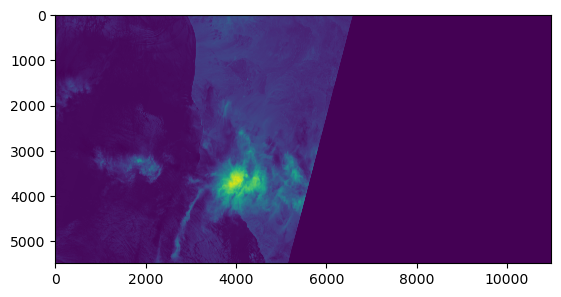

<Axes: >

In [1]:
import boto3
import rasterio
import matplotlib.pyplot as plt

from rasterio.plot import show

cog_url = 's3://sentinel-cogs/sentinel-s2-l2a-cogs/12/R/UU/2024/4/S2A_12RUU_20240421_0_L2A/B02.tif'

# Don't forget to create an AWS session with unsigned requests enabled!
aws_session = rasterio.session.AWSSession(boto3.Session(), aws_unsigned=True)

# Open the COG and read the right half
with rasterio.Env(aws_session):
    with rasterio.open(cog_url) as dataset:
        # Define the window for the bottom of the COG
        width = dataset.width
        height = dataset.height
        bottom_half_window = rasterio.windows.Window(
            col_off=0, row_off=height // 2, width=width, height=height
        )

        # Read the data for the right half
        bottom_half_data = dataset.read(1, window=bottom_half_window)

show(bottom_half_data)

### Detailed Demonstration

Now that we've seen how to quickly and efficiently read a specific region of a Cloud-Optimized GeoTIFF (COG) in the TL;DR section immediately above, let’s explore things in greater detail. We'll start with some necessary imports.

In [2]:
import boto3
import rasterio

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from rasterio.plot import show
from rasterio.session import AWSSession
from rasterio.windows import from_bounds, Window

### Logging Byte-Range Requests

To demonstrate how Cloud-Optimized GeoTIFFs (COGs) enable request-specific access, we will first set up logging to surface the byte-ranges requested by GDAL. These logs should show how only the necessary portions of the dataset are fetched from the cloud, rather than downloading the entire file.

This logging provides a view into the mechanics of COG access. It is in no way necessary under normal usage of these libraries!


In [3]:
# imports specific to setting up GDAL logging
import logging
import os

# Enable GDAL logging; cf https://gdal.org/en/stable/user/configoptions.html
os.environ["CPL_LOG"] = "/dev/stdout"
os.environ["CPL_DEBUG"] = "ON"

logging.basicConfig(level=logging.DEBUG)
logger = logging.getLogger()
handler = logging.StreamHandler()
formatter = logging.Formatter('%(message)s')
handler.setFormatter(formatter)
logger.handlers = [handler]

# The logs tend to be chatty, so we'll filter them down to only those describing what is being read
class GdalFilter(logging.Filter):
    def filter(self, record):
        msg = record.getMessage()
        return "Downloading" in msg or "HTTP GET request" in msg

handler.addFilter(GdalFilter())

### Setting Up the COG URL and AWS Session

For this demonstration, we can use a free, publicly available Sentinel-2 Cloud-Optimized GeoTIFF (COG) [hosted on AWS](https://registry.opendata.aws/sentinel-2/). This dataset provides high-resolution satellite imagery and from the [Sentinel-2 program](https://sentiwiki.copernicus.eu/web/s2-mission). 

The specific file we are accessing contains **Band 2 (Blue)** data for a tile in the UTM Zone 12N.

Since this dataset is publicly accessible, we need to set up an **AWS session** with unsigned requests to access the file without authentication.

In [4]:
cog_url = 's3://sentinel-cogs/sentinel-s2-l2a-cogs/12/R/UU/2024/4/S2A_12RUU_20240421_0_L2A/B02.tif'

# Don't forget to create an AWS session with unsigned requests enabled!
aws_session = AWSSession(boto3.Session(), aws_unsigned=True)

### Understanding the Internal Tile Grid of the COG

This section computes and visualizes the internal tile grid of a Cloud-Optimized GeoTIFF (COG). By understanding how tiles are arranged, we can align requests with the internal structure of the COG to optimize access.

#### Steps in the Code:

1. **Read Metadata**:
   - The raster's metadata is accessed using `rasterio.open`. This includes:
     - **Bounds**: Geographic extent of the raster (xmin, xmax, ymin, ymax).
     - **Resolution**: Geographic units per pixel (width, height).
     - **Block Shapes**: Internal tile size in pixels, retrieved from `block_shapes`.

2. **Calculate Tile Dimensions**:
   - The tile size in geographic units is computed by multiplying the pixel dimensions of a tile by the raster's resolution:
     - `tile_width = block_width * res[0]`
     - `tile_height = block_height * res[1]`

3. **Generate Grid Coordinates**:
   - The grid coordinates for tile boundaries are calculated based on the raster's extent and tile size:
     - Horizontal (`x`) coordinates span from `bounds.left` to `bounds.right`, incremented by `tile_width`.
     - Vertical (`y`) coordinates span from `bounds.top` to `bounds.bottom`, decremented by `tile_height` (to align with the raster's coordinate system).

#### Notes on Efficiency:
- The logs confirm that **only metadata stored in the file header is read** during this operation. No pixel data is accessed and only the byte-range 0-16383 is transferred!
- This efficient metadata access highlights the design of COGs, which store critical structural information in the header.

This step sets the stage for visualizing the grid, constructing our read-window, and understanding how tiles align with the raster's extent.

In [5]:
with rasterio.Env(aws_session):  # Set environment for unsigned access
    with rasterio.open(cog_url) as dataset:
        # Get raster metadata
        bounds = dataset.bounds
        res = dataset.res  # Resolution (width, height) in geographic units per pixel
        block_width, block_height = dataset.block_shapes[0]  # Block size (tile dimensions in pixels)

        tile_width = block_width * res[0]
        tile_height = block_height * res[1]

        # Compute grid coordinates
        x_coords = list(range(int(bounds.left), int(bounds.right), int(tile_width)))
        y_coords = list(range(int(bounds.top), int(bounds.bottom), -int(tile_height)))

CPLE_None in S3: Downloading 0-16383 (https://sentinel-cogs.s3.amazonaws.com/sentinel-s2-l2a-cogs/12/R/UU/2024/4/S2A_12RUU_20240421_0_L2A/B02.tif)...


### Overviews for Efficient Visualization

To visualize the raster efficiently, we leverage Cloud-Optimized GeoTIFF (COG) overviews. Overviews are precomputed, lower-resolution versions of the raster data stored within the file.

Let's first see the available overviews and do a bit of math to estimate how much less data we need to read for each:

In [6]:
with rasterio.Env(aws_session):
    with rasterio.open(cog_url) as dataset:
        overviews = dataset.overviews(1)
        pixels_wide = dataset.width
        pixel_high = dataset.height

full_res_pixels = pixels_wide * pixel_high
print(f"Available overviews: {overviews}; total pixels in full resolution image: {full_res_pixels}")
for idx, overview in enumerate(overviews):
    print(f"With index {idx} and value {overview}, we should have approximately {int(full_res_pixels / (overview * overview))} pixels. That's {overview * overview}x fewer pixels!")

Available overviews: [2, 4, 8, 16]; total pixels in full resolution image: 120560400
With index 0 and value 2, we should have approximately 30140100 pixels. That's 4x fewer pixels!
With index 1 and value 4, we should have approximately 7535025 pixels. That's 16x fewer pixels!
With index 2 and value 8, we should have approximately 1883756 pixels. That's 64x fewer pixels!
With index 3 and value 16, we should have approximately 470939 pixels. That's 256x fewer pixels!


#### Explanation:
- **2**: Represents the first overview, where the resolution is reduced to 1/2 in both dimensions.
- **4**: Represents the second overview, where the resolution is reduced to 1/4th in both dimensions.
- **8**: Represents the third overview, where the resolution is reduced to 1/8th in both dimensions.
- **16**: Represents the fourth overview, where the resolution is reduced to 1/16th in both dimensions.

#### Why Overviews Matter:
- **Faster Performance**: By leveraging these precomputed overviews, applications can quickly fetch data at lower resolutions without processing the full dataset.
- **Reduced Data Transfer**: Overviews minimize the amount of data read from the file, which is especially important when working with large datasets in cloud environments.

In the following cell:
- The `OVERVIEW_LEVEL` is set to `3`, which selects the overview with the lowest resolution in this tif. Referring to the explanation above, that means 1/16th resolution in both `x` and `y` dimensions!
- The `dataset.read` function retrieves the first band, resampling the overview to an output shape of `512x512` pixels for display.

Take note of how small the byte-range request surfaced in logs are. We get to see a (low resolution) version of the entirety of this tif without moving much data across the wire. This is the advantage of provided overviews.

In [7]:
with rasterio.Env(aws_session):
    with rasterio.open(cog_url, OVERVIEW_LEVEL=3) as dataset:
        overview = dataset.read(1, out_shape=(512, 512))

CPLE_None in S3: Downloading 16384-393215 (https://sentinel-cogs.s3.amazonaws.com/sentinel-s2-l2a-cogs/12/R/UU/2024/4/S2A_12RUU_20240421_0_L2A/B02.tif)...


### Visualizing the First Tile with the Internal Tile Grid

This code block creates a visualization of the Cloud-Optimized GeoTIFF (COG) and its internal tiling structure:

1. **Plotting the Overview**:
   - The overview raster data is displayed using `imshow`, with the coordinate extent (`bounds`) ensuring the geographic alignment of the visualization.
   - The title and axis labels provide context, specifying the coordinate reference system (CRS) as EPSG 9807.

2. **Adding Grid Lines**:
   - Red vertical and horizontal lines are drawn to represent the boundaries of the internal tiles.
   - These lines are calculated based on the tile dimensions and the raster's geographic extent.

3. **Highlighting the First Tile**:
   - A blue rectangle is drawn around the first tile (top-left corner) of the raster.
   - The rectangle is calculated using the geographic coordinates of the tile's extent, emphasizing alignment with the internal tiling structure.

This visualization illustrates the COG's tile grid. The grid is important because it is what lets tools like rasterio decide how - and how much - to read. 
> Note: At the risk of being repetitive, please be aware that you won't actually have to think about this kind of implementation detail when working with COGs - in practice, they just work and will save you time, data, and memory if you only need part of a TIF!

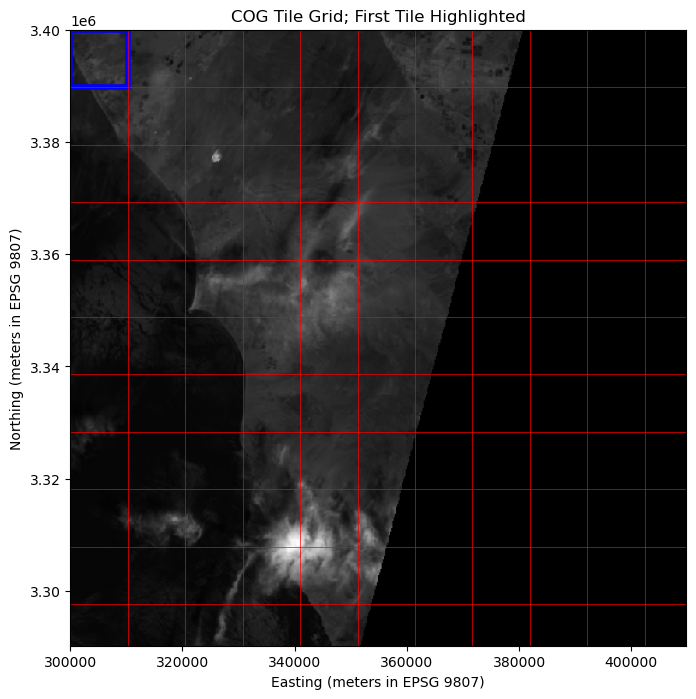

In [8]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.imshow(overview, cmap="gray", extent=[bounds.left, bounds.right, bounds.bottom, bounds.top])
ax.set_title("COG Tile Grid; First Tile Highlighted")
ax.set_xlabel("Easting (meters in EPSG 9807)")
ax.set_ylabel("Northing (meters in EPSG 9807)")

# Add grid lines
for x in x_coords:
    ax.axvline(x=x, color="red", linewidth=0.5)
for y in y_coords:
    ax.axhline(y=y, color="red", linewidth=0.5)

# Highlight the first tile (top-left)
first_tile_xmin = bounds.left
first_tile_xmax = bounds.left + tile_width
first_tile_ymax = bounds.top
first_tile_ymin = bounds.top - tile_height
rect = Rectangle(
    (first_tile_xmin, first_tile_ymin),
    tile_width,
    tile_height,
    linewidth=4,
    edgecolor="blue",
    facecolor="none",
)
ax.add_patch(rect)

plt.show()

### Reading and Visualizing the First Full Tile

In this step, we read and visualize the **first full tile** of the dataset, aligned with the internal tiling structure of the Cloud-Optimized GeoTIFF (COG). This demonstrates the efficiency of accessing data in tile-sized chunks, a best-case scenario for COGs.

#### Steps:

1. **Define the tile window**:
   - The window corresponds to the first tile (top-left corner), with dimensions matching the internal tile size provided by the dataset's `block_shapes`.

2. **Read the tile data**:
   - The `rasterio.read` function fetches the data for the first tile.
   - *NOTE:* Logs starting with `CPLE_None` describe the byte ranges accessed for this operation.

3. **Visualize the Tile**:
   - The tile is plotted with pixel-based x and y axes.
  
#### Significance of logs

Pay attention to the logs, starting with 'CPLE_None'. They indicate which bytes needed to be downloaded. As you can see, this read required only one request!

CPLE_None in S3: Downloading 31424512-32784383 (https://sentinel-cogs.s3.amazonaws.com/sentinel-s2-l2a-cogs/12/R/UU/2024/4/S2A_12RUU_20240421_0_L2A/B02.tif)...


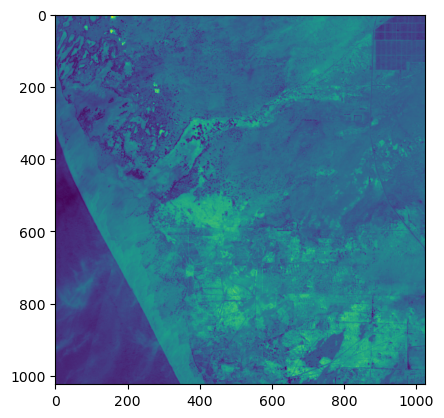

In [9]:
with rasterio.Env(aws_session):
    with rasterio.open(cog_url) as src:
        first_tile_window = Window(col_off=0, row_off=0, width=block_width, height=block_height)
        first_tile = src.read(1, window=first_tile_window)
        show(first_tile)

### Visualizing a Region Spanning Multiple Tiles with the Internal Tile Grid

This section visualizes a region that spans portions of multiple tiles in a Cloud Optimized GeoTiff (COG). This scenario is less optimal than the above, as requests are not neatly aligned with the internal tile grid.


1. **Plotting the Overview**:
   - The overview raster data is displayed using `imshow`, with the coordinate extent (`bounds`) ensuring the geographic alignment of the visualization.
   - The title and axis labels provide context, specifying the coordinate reference system (CRS) as EPSG 9807.

2. **Adding Grid Lines**:
   - Red vertical and horizontal lines are drawn to represent the boundaries of the internal tiles.
   - These lines are calculated based on the tile dimensions and the raster's geographic extent.

3. **Highlighting the Area of Interest**:
   - A blue rectangle is drawn around a region which is centered on the intersection of the square of tiles found in the top-left of the raster.

#### Insights:
- This demonstrates how COGs handle non-aligned access patterns while still reading only the necessary byte ranges.
- The visualization highlights the relationship between the requested region and the internal tile grid.

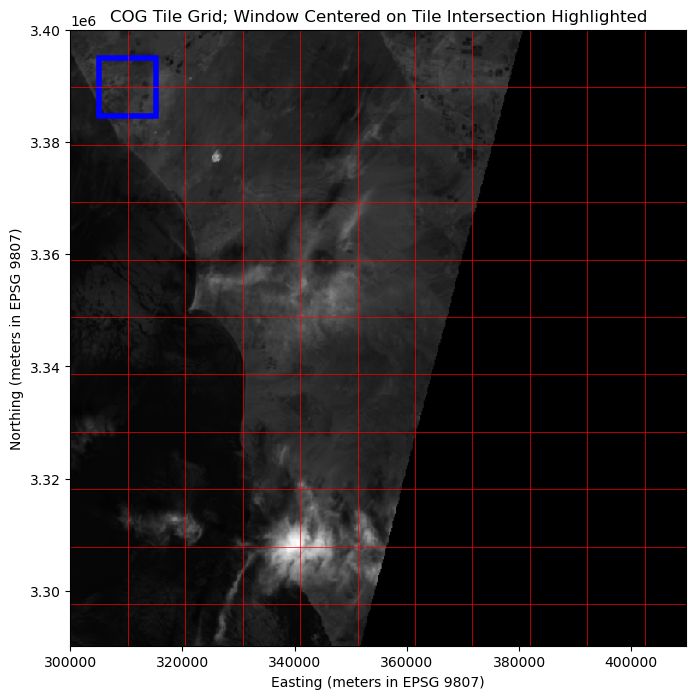

In [10]:
# Define the region spanning multiple tiles
intersection_xmin = bounds.left + tile_width * 0.5
intersection_xmax = bounds.left + tile_width * 1.5
intersection_ymax = bounds.top - tile_height * 0.5
intersection_ymin = bounds.top - tile_height * 1.5

# Plot the raster with the grid
fig, ax = plt.subplots(figsize=(10, 8))
ax.imshow(overview, cmap="gray", extent=[bounds.left, bounds.right, bounds.bottom, bounds.top])
ax.set_title("COG Tile Grid; Window Centered on Tile Intersection Highlighted")
ax.set_xlabel("Easting (meters in EPSG 9807)")
ax.set_ylabel("Northing (meters in EPSG 9807)")

# Add grid lines
for x in x_coords:
    ax.axvline(x=x, color="red", linewidth=0.5)
for y in y_coords:
    ax.axhline(y=y, color="red", linewidth=0.5)

# Highlight the read area
read_area = Rectangle(
    (intersection_xmin, intersection_ymin),
    intersection_xmax - intersection_xmin,
    intersection_ymax - intersection_ymin,
    linewidth=4,
    edgecolor="blue",
    facecolor="none",
)
ax.add_patch(read_area)

plt.show()

### Reading and Visualizing a Region Spanning Multiple Tiles

In this step, we read and visualize a region that spans portions of four tiles in the dataset. This operation demonstrates the efficiency of Cloud-Optimized GeoTIFFs (COGs) even in less-optimal scenarios where the requested region intersects multiple tiles.

#### Steps:

1. **Define the overlapping tile window**:
   - The window is defined using geographic bounds, ensuring it intersects the boundaries of four internal tiles.

2. **Read the data for the overlapping region**:
   - The `rasterio.read` function fetches the data for the specified window.
   - *NOTE:* Logs starting with `CPLE_None` describe the byte ranges accessed for this operation.

3. **Visualize the Data**:
   - The overlapping region is plotted with pixel-based x and y axes.

#### Significance of Logs

Pay attention to the logs, starting with 'CPLE_None'. They indicate which bytes were downloaded. Despite the region spanning **four tiles**, the file structure allows for **only two HTTP range requests**. How is that possible? Behind the scenes, rasterio (GDAL, actually) is able to determine that these four tiles consist of only two contiguous blocks of bytes!

CPLE_None in S3: Downloading 31426851-33977114 (https://sentinel-cogs.s3.amazonaws.com/sentinel-s2-l2a-cogs/12/R/UU/2024/4/S2A_12RUU_20240421_0_L2A/B02.tif)...
CPLE_None in S3: Downloading 41301455-43892593 (https://sentinel-cogs.s3.amazonaws.com/sentinel-s2-l2a-cogs/12/R/UU/2024/4/S2A_12RUU_20240421_0_L2A/B02.tif)...


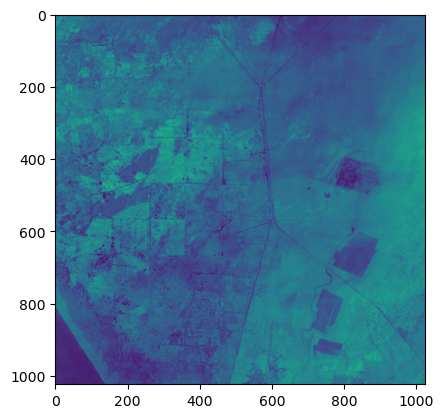

In [11]:
with rasterio.Env(aws_session):
    with rasterio.open(cog_url) as src:
        intersection_window = from_bounds(
            intersection_xmin, intersection_ymin,
            intersection_xmax, intersection_ymax,
            transform=src.transform
        )
        intersection_data = src.read(1, window=intersection_window)
        show(intersection_data)

## Review of Key Points

In this notebook, we demonstrated the efficiency of accessing geospatial data stored in a **Cloud-Optimized GeoTIFF (COG)** using `rasterio`. The key takeaways include:

1. **Efficient Data Access**:
   - COGs enable on-demand access to specific subsets of a dataset, avoiding the need to download entire files.
   - We saw the efficiency of reading a **single tile** (aligned with the grid) and a region spanning **multiple tiles**.
   - By aligning requests with the tile grid, we get optimal performance, minimizing unnecessary reads.

3. **Insights From Logged Byte-Range Requests**:
   - Logs showed that COGs allow us to minimize data transfer. Reads are grouped according to contiguous byte ranges to reduce requests.
   - For the single tile read, only one byte-range request was required, while the overlapping region spanning four tiles was fetched in just two requests.